**LUNGS SEGMENTATION USING UNET- ARCHITECTURE**

> 



Import packages

In [1]:
import tensorflow as tf
import numpy as np
import cv2 as opencv
from tensorflow.keras import models ,layers
from tensorflow.keras.models import *
from matplotlib import pyplot as plt

Mount drives:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Creating Data Set from images and mask**

In [3]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf

def load_data(path):
    images = sorted(glob(os.path.join(path, "image/*")))
    masks = sorted(glob(os.path.join(path, "mask/*")))

    return images, masks

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x / 255.0
    x = np.expand_dims(x, axis=-1)
    x = x.astype(np.float32)
    return x

def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        x = read_image(x)
        y = read_mask(y)

        return x, y

    images, masks = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    images.set_shape([256, 256, 3])
    masks.set_shape([256, 256, 1])

    return images, masks

def tf_dataset(x, y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset



In [4]:

p = "/content/drive/MyDrive/Colab Notebooks/Outputs/"
path = p
images, masks = load_data(path)
print(f"Images: {len(images)} - Masks: {len(masks)}")
dataset = tf_dataset(images, masks)


Images: 838 - Masks: 838


In [5]:
print(len(dataset))

419


In [6]:
def split_data(ds, train_split = 0.8, val_split=0.1, test_split= 0.1, shuffle_size=10000):
    ds = ds.shuffle(shuffle_size, seed=12)
    total_length = len(ds)
    train_ds = ds.take(int(total_length*train_split))
    validation_ds = ds.skip(int(total_length*train_split)).take(int(total_length * val_split))
    test_ds = ds.skip(int(train_split*total_length)).skip(int(total_length* val_split))
    
    return train_ds, validation_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = split_data(dataset)

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

335
41
43


# Visualizing Data along with mask

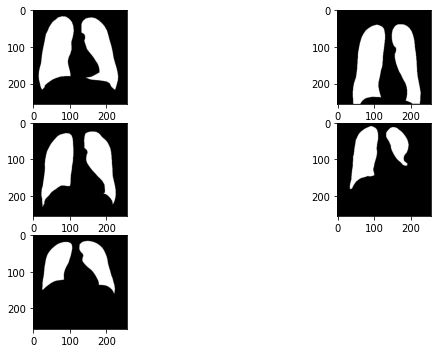

In [ ]:
plt.figure(figsize=(10,10))
for i in range(5):
  m =  (train_y[i].numpy()*255).astype('uint8')
  plt.subplot(5, 2, i+1)
  plt.imshow(m)

# Model **Building**

Architecture:

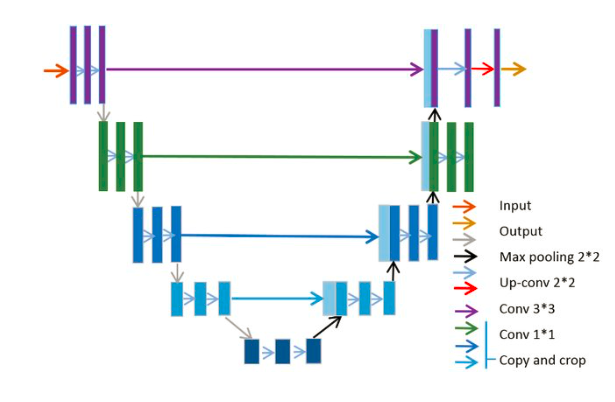

In [33]:
shape = (256, 256, 3)
    
input = layers.Input(shape)
# Encoder.
#Encoder batch 1:
c1 = layers.Conv2D(filters=32, kernel_size = (3,3), activation='relu', padding='same')(input)
c1 =  layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(c1)
c1 = layers.Dropout(0.2)(c1)

#Encoder batch 2:
p1 = layers.MaxPooling2D(2,2)(c1)
c2 = layers.Conv2D(filters=64, kernel_size = (3,3), activation='relu', padding='same')(p1)
c2 =  layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(c2)
c2 = layers.Dropout(0.2)(c2)

#Encoder batch 3:
p2 = layers.MaxPooling2D((2,2))(c2)
c3 = layers.Conv2D(filters=128, kernel_size = (3,3), activation='relu', padding='same')(p2)
c3 =  layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(c3)
c3 = layers.Dropout(0.2)(c3)

#Encoder batch 4:
p3 =  layers.MaxPooling2D((2,2))(c3)
c4 = layers.Conv2D(filters=256, kernel_size = (3,3), activation='relu', padding='same')(p3)
c4 =  layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(c4)
c4 = layers.Dropout(0.2)(c4)


#Encoder batch 5:
p4 = layers.MaxPooling2D((2,2))(c4)
c5 = layers.Conv2D(filters=512, kernel_size = (3,3), activation='relu', padding='same')(p4)
c5 =  layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(c5)
c5 = layers.Dropout(0.2)(c5)


# Decoder Batch:

#Batch 1:
u1 = (layers.UpSampling2D(size=(2,2))(c5))
u1 = layers.concatenate([u1, c4])
u1 = layers.Dropout(0.2)(u1)
c6 = layers.Conv2D(filters=256, kernel_size=(2,2), activation='relu', padding='same')(u1)
c6 = layers.Conv2D(filters=256, kernel_size=(2,2), activation='relu', padding='same')(c6)

#Batch 2:

u2 = (layers.UpSampling2D(size=(2,2))(c6))
u2 = layers.concatenate([u2, c3])
u2 = layers.Dropout(0.2)(u2)
c7 = layers.Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same')(u2)
c7 = layers.Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same')(c7)


#Batch 3:

u3 = (layers.UpSampling2D(size=(2,2))(c7))
u3 = layers.concatenate([u3, c2])
u3 = layers.Dropout(0.2)(u3)
c8 = layers.Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(u3)
c8 = layers.Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(c8)

#Batch 4:

u4 = (layers.UpSampling2D(size=(2,2))(c8))
u4 = layers.concatenate([u4, c1])
u4 = layers.Dropout(0.2)(u4)
c9 = layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(u4)
c9 = layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(c9)

#Batch 5:

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
model = tf.keras.Model(inputs=input, outputs=[outputs])

model.compile(optimizer='Adam', loss='BinaryCrossentropy',
                  metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [13]:
history = model.fit(
    
    dataset,
    verbose=1, 
    epochs=25
    
    )

Epoch 1/25
419/419 [==============================] - 764s 2s/step - loss: 0.3552 - accuracy: 0.8279
Epoch 2/25
419/419 [==============================] - 47s 111ms/step - loss: 0.1067 - accuracy: 0.9548
Epoch 3/25
419/419 [==============================] - 44s 105ms/step - loss: 0.0949 - accuracy: 0.9593
Epoch 4/25
419/419 [==============================] - 44s 105ms/step - loss: 0.0823 - accuracy: 0.9644
Epoch 5/25
419/419 [==============================] - 44s 104ms/step - loss: 0.0744 - accuracy: 0.9672
Epoch 6/25
419/419 [==============================] - 45s 107ms/step - loss: 0.0694 - accuracy: 0.9695
Epoch 7/25
419/419 [==============================] - 43s 104ms/step - loss: 0.0677 - accuracy: 0.9700
Epoch 8/25
419/419 [==============================] - 44s 104ms/step - loss: 0.0699 - accuracy: 0.9699
Epoch 9/25
419/419 [==============================] - 44s 104ms/step - loss: 0.0646 - accuracy: 0.9716
Epoch 10/25
419/419 [==============================] - 44s 104ms/step - los

In [17]:
model.save('/content/drive/MyDrive/Colab Notebooks/models/segmentation.h5')

In [9]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/models/segmentation.h5')

# **Output**

In [53]:
def img_to_tensor(img):
  img_new=opencv.resize(img, (256,256))
  image_tensor = tf.convert_to_tensor(img_new, dtype=tf.float32)
  # Add dimension to match with input mode 
  image_tensor = tf.expand_dims(image_tensor, 0)


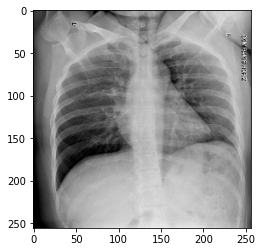

In [50]:
img= opencv.imread('/content/drive/MyDrive/Colab Notebooks/Outputs/unseen/id_df9b2d92-37d13be4-2354f2ed-3bc8f182-274587b6_Study_07893202.73917921.58964576.32858798.72626666_Series_58708914.07639187.10301794.43600876.84800964_image-69487196-14640496-31698335-827.jpg', opencv.IMREAD_COLOR)
img=opencv.resize(img, (256,256))
plt.imshow(img)
image_tensor = tf.convert_to_tensor(img, dtype=tf.float32)

# Add dimension to match with input mode 
image_tensor = tf.expand_dims(image_tensor, 0)


Text(0.5, 1.0, 'Mask')

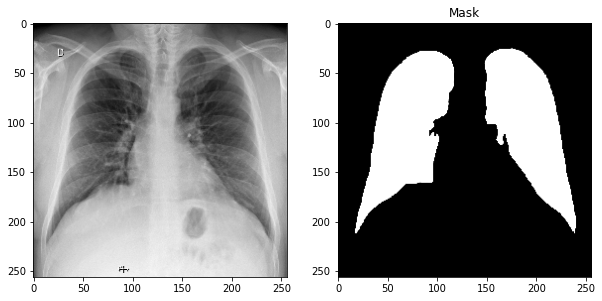

In [57]:
plt.figure(figsize=(10, 10))
img = opencv.imread('/content/drive/MyDrive/Colab Notebooks/Outputs/unseen/id_00a923da-bd1a1ce4-7604d73a-c1d0ea51-f8be8c0a_Study_49022860.51817301.33001369.12414796.10234011_Series_46356286.40162912.86427992.60165144.80642054_image-58704836-44592521-53500194-715.jpg')
img=opencv.resize(img, (256,256))
plt.subplot(1,2,1)
plt.imshow(img)
image_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
# Add dimension to match with input mode 
image_tensor = tf.expand_dims(image_tensor, 0)
pred = new_model.predict(image_tensor)
plt.subplot(1,2,2)
plt.imshow((pred*255).astype(np.uint8).reshape(256,256), cmap='gray')
plt.title('Mask')

Text(0.5, 1.0, 'Mask')

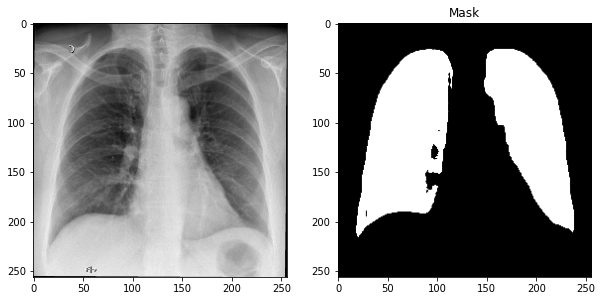

In [58]:
plt.figure(figsize=(10, 10))
img = opencv.imread('/content/drive/MyDrive/Colab Notebooks/Outputs/unseen/id_00c17ded-70f9d85e-1d1e9329-ffcd74a2-fdf802be_Study_47978244.48435686.21317030.03499961.45571941_Series_88875657.82551783.33020737.08081710.78486391_image-95405448-26419303-92637870-150.jpg')
img=opencv.resize(img, (256,256))
plt.subplot(1,2,1)
plt.imshow(img)
image_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
# Add dimension to match with input mode 
image_tensor = tf.expand_dims(image_tensor, 0)
pred = new_model.predict(image_tensor)
plt.subplot(1,2,2)
plt.imshow((pred*255).astype(np.uint8).reshape(256,256), cmap='gray')
plt.title('Mask')

Text(0.5, 1.0, 'Mask')

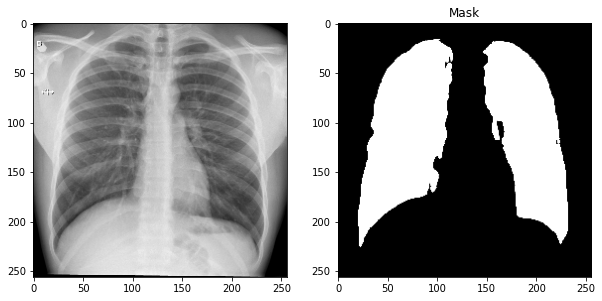

In [59]:
plt.figure(figsize=(10, 10))
img = opencv.imread('/content/drive/MyDrive/Colab Notebooks/Outputs/unseen/id_d215830e-435f6431-565fedee-659afc0a-040b89c4_Study_13099209.36477796.74662327.68485653.33776922_Series_67807255.81818480.49118026.46597785.02912165_image-59670976-51227249-38148780-854.jpg')
img=opencv.resize(img, (256,256))
plt.subplot(1,2,1)
plt.imshow(img)
image_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
# Add dimension to match with input mode 
image_tensor = tf.expand_dims(image_tensor, 0)
pred = new_model.predict(image_tensor)
plt.subplot(1,2,2)
plt.imshow((pred*255).astype(np.uint8).reshape(256,256), cmap='gray')
plt.title('Mask')

**Performance Check**

In [32]:
# F1 score of test data set
from sklearn.metrics import f1_score
# Take all labels of test data
temp = []
pred_y=[]
for x, y in test_ds.take(43):
  y1 = y[0].numpy().astype('uint8')
  y1 = np.resize(y1, (256,256))
  y1_t1 = y1[0].flatten()
  y1_t2 = y1[1].flatten()
  y2 = y[1].numpy().astype('uint8')
  y2 = np.resize(y2, (256,256))
  y2_t1 = y2[0].flatten()
  y2_t2 = y2[1].flatten()
  for i in y1_t1:
    temp.append(i)
  for i in y1_t2:
    temp.append(i)
  for i in y2_t1:
    temp.append(i)
  for i in y2_t2:
    temp.append(i)
  lab = new_model.predict(x)
  p1 = lab[0].astype('uint8')
  p1 = np.resize(p1, (256,256))
  p1_t1 = p1[0].flatten()
  p1_t2 = p1[1].flatten()
  p2 = lab[1].astype('uint8')
  p2 = np.resize(p2, (256,256))
  p2_t1 = p2[0]
  p2_t2 = p2[1]
  for i in p1_t1:
    pred_y.append(i)
  for i in p1_t2:
    pred_y.append(i)
  for i in p2_t1:
    pred_y.append(i)
  for i in p2_t2:
    pred_y.append(i)
  

validation_accuracy = f1_score(temp, pred_y, average='weighted')
print(f' f1 score is {validation_accuracy}')



 f1 score is 0.9983991767058544
